# Combined Autoencoder Analysis (Standard vs. Conditional)
This notebook trains both a standard Autoencoder (AE) and a Conditional Autoencoder (CAE) on the z500 data, performs clustering on their latent spaces, and compares the results.

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import os

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, silhouette_score

import tensorflow as tf
from tensorflow import keras

import clustering_functions as cf
import ae_models
import ae_training

print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/tyler/local-docs/CMU/Neural-Netbusters/RMM-VAE


## 1. Load and Preprocess Data

In [2]:
# Execute the preprocessing script to load and prepare data
# This script should define z500, pr, z500_reshaped, threshold_qn95, pr_spatial etc.
exec(open('pre_processing.py').read())

# Define common parameters
nt, ny, nx = z500.shape
input_dim = ny * nx
latent_dim = 10
epochs = 50
batch_size = 32
k = 5 # Number of clusters
k_range = range(4, 11)

# Create directories for plots
filepath_ae = 'plots/ae/'
filepath_cae = 'plots/cae/'
filepath_combined = 'plots/combined_ae/'
os.makedirs(filepath_ae, exist_ok=True)
os.makedirs(filepath_cae, exist_ok=True)
os.makedirs(filepath_combined, exist_ok=True)

## 2. Standard Autoencoder (AE)

### 2.1 Build and Train AE

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 286)]             0         
                                                                 
 encoder_dense_1 (Dense)     (None, 256)               73472     
                                                                 
 encoder_dense_2 (Dense)     (None, 32)                8224      
                                                                 
 latent_space (Dense)        (None, 10)                330       
                                                                 
 decoder_dense_1 (Dense)     (None, 32)                352       
                                                                 
 decoder_dense_2 (Dense)     (None, 256)               8448      
                                                                 
 reconstruction (Dense)      (None, 286)               

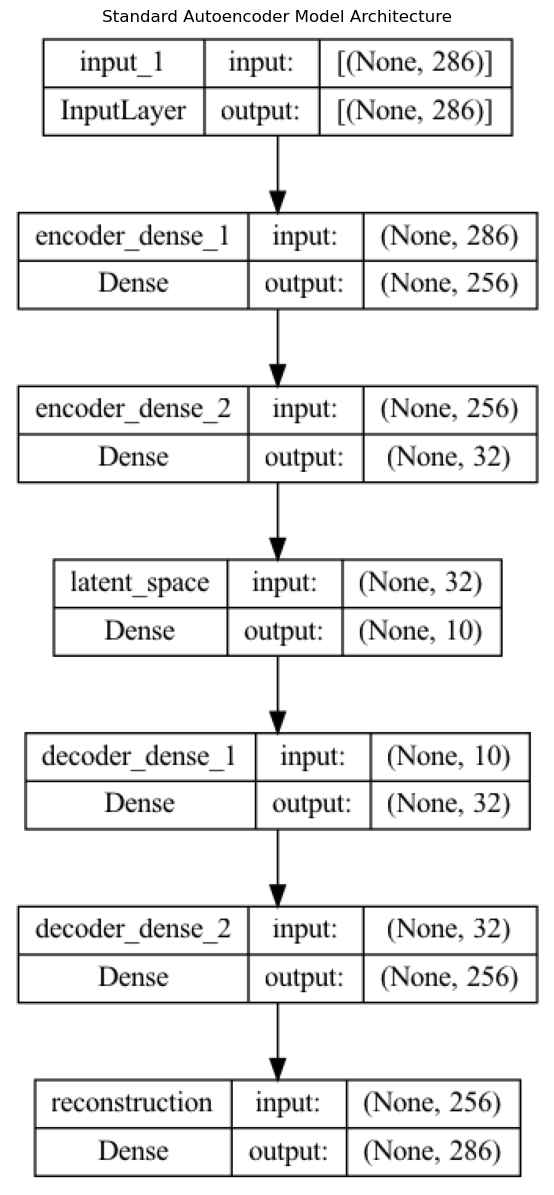

Epoch 1/50
314/314 [==============================] - 1s 2ms/step - loss: 0.2046 - val_loss: 0.0871
Epoch 2/50
314/314 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.0482
Epoch 3/50
314/314 [==============================] - 1s 2ms/step - loss: 0.0447 - val_loss: 0.0443
Epoch 4/50
314/314 [==============================] - 1s 2ms/step - loss: 0.0418 - val_loss: 0.0414
Epoch 5/50
314/314 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0412
Epoch 6/50
314/314 [==============================] - 1s 2ms/step - loss: 0.0395 - val_loss: 0.0418
Epoch 7/50
314/314 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0390
Epoch 8/50
314/314 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0398
Epoch 9/50
314/314 [==============================] - 1s 2ms/step - loss: 0.0381 - val_loss: 0.0383
Epoch 10/50
314/314 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0384

In [3]:
autoencoder_ae, encoder_ae, decoder_ae = ae_models.build_autoencoder(input_dim, latent_dim)
autoencoder_ae.compile(optimizer='adam', loss='mse')
autoencoder_ae.summary()

# Plot model architecture
model_diagram_path_ae = filepath_ae + 'autoencoder_diagram.png'
tf.keras.utils.plot_model(autoencoder_ae, to_file=model_diagram_path_ae, show_shapes=True, show_layer_names=True)
img_ae = plt.imread(model_diagram_path_ae)
plt.figure(figsize=(10, 15))
plt.imshow(img_ae)
plt.axis('off')
plt.title('Standard Autoencoder Model Architecture')
plt.show()

# Train AE
history_ae = ae_training.train_autoencoder(autoencoder_ae, z500_reshaped, epochs=epochs, batch_size=batch_size, validation_split=0.2, random_state=42, save_path=filepath_ae+'model.keras')

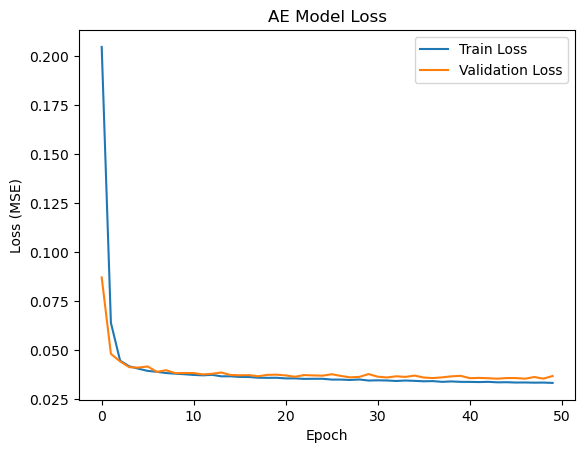

In [4]:
# Plot AE training loss
plt.figure()
plt.plot(history_ae.history['loss'], label='Train Loss') 
plt.plot(history_ae.history['val_loss'], label='Validation Loss')
plt.title('AE Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(filepath_ae + 'training_loss.png')
plt.show()

### 2.2 AE Latent Space Clustering and Analysis

In [5]:
# Get AE latent representation
z500_latent_ae = encoder_ae.predict(z500_reshaped)

# K-means clustering
ae_clusters = KMeans(n_clusters=k, n_init=50, random_state=0).fit(z500_latent_ae)
latent_centroids_ae = ae_clusters.cluster_centers_

# Decode centroids
centroids_reconstructed_ae = decoder_ae.predict(latent_centroids_ae)
centroids_ae = centroids_reconstructed_ae.reshape(k, ny, nx, order='F')
centroids_ae_xr = xr.DataArray(centroids_ae, coords=z500[0:k, :, :].coords, dims=z500[0:k, :, :].dims, attrs=z500[0:k, :, :].attrs)

# Save centroids
centroids_ae_flat = cf.reshape_data_for_clustering(centroids_ae_xr)
df_ae_centroids = pd.DataFrame(data=centroids_ae_flat)
df_ae_centroids.to_csv(filepath_ae + f'cluster_centers_{k}.csv')

1/1 [==============================] - 0s 24ms/step


AE Silhouette Score for k=4: 0.1674855500459671
AE Silhouette Score for k=5: 0.1297217607498169
AE Silhouette Score for k=6: 0.13513284921646118
AE Silhouette Score for k=7: 0.1337066888809204
AE Silhouette Score for k=8: 0.13085639476776123
AE Silhouette Score for k=9: 0.1338110715150833
AE Silhouette Score for k=10: 0.11967945098876953


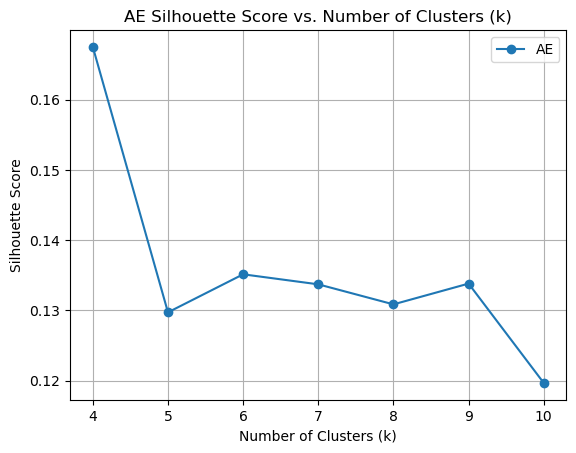

In [6]:
# Calculate and plot Silhouette Score for AE
silhouette_scores_ae = []
for k_test in k_range:
    kmeans_test = KMeans(n_clusters=k_test, n_init=50, random_state=0).fit(z500_latent_ae)
    score = silhouette_score(z500_latent_ae, kmeans_test.labels_)
    silhouette_scores_ae.append(score)
    print(f'AE Silhouette Score for k={k_test}: {score}')

plt.figure()
plt.plot(k_range, silhouette_scores_ae, marker='o', label='AE')
plt.title('AE Silhouette Score vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.legend()
plt.savefig(filepath_ae + 'silhouette_score_vs_k.png')
plt.show()

In [ ]:
# Reorder AE cluster labels based on precipitation
pr_labeled_ae = cf.assign_labels(xarray_array=pr, labels=ae_clusters.labels_)
pr_by_label_ae = pr_labeled_ae.groupby('label').mean(dim=['time', 'latitude', 'longitude'])
cluster_order_ae = np.flip(np.argsort(pr_by_label_ae.values)).tolist()
dict_replace_ae = {i: cluster_order_ae.index(i) for i in range(k)}
vfunc_ae = np.vectorize(lambda x: dict_replace_ae.get(x, x))
relabeled_labels_ae = vfunc_ae(ae_clusters.labels_)
df_ae_labels = pd.DataFrame({'Labels': 'AE', 'Value': relabeled_labels_ae})
df_ae_labels.to_csv(filepath_ae + 'relabeled_labels.csv')

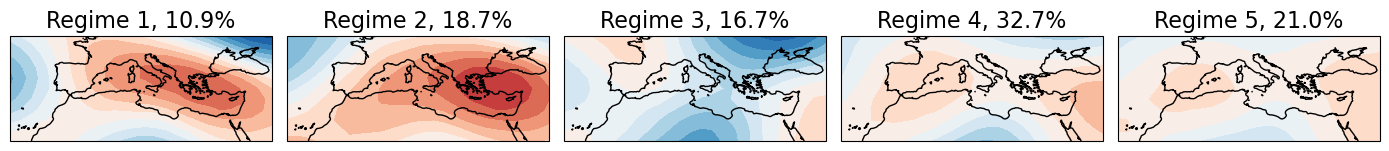

In [8]:
# Visualise AE cluster centers
clusters_ae_vis = cf.visualise_contourplot(dataset_xarray=centroids_ae_xr,
                                           unit='[m]',
                                           cluster_results=ae_clusters,
                                           cluster_order=cluster_order_ae,
                                           regime_names=[f'Regime {i+1}' for i in range(k)],
                                           vmin=-1.7, vmax=1.7, steps=0.2, col_number=k,
                                           color_scheme='RdBu_r', borders=False,
                                           projection=ccrs.PlateCarree(central_longitude=0))
plt.savefig(filepath_ae + f'cluster_visualisation_{k}.png')

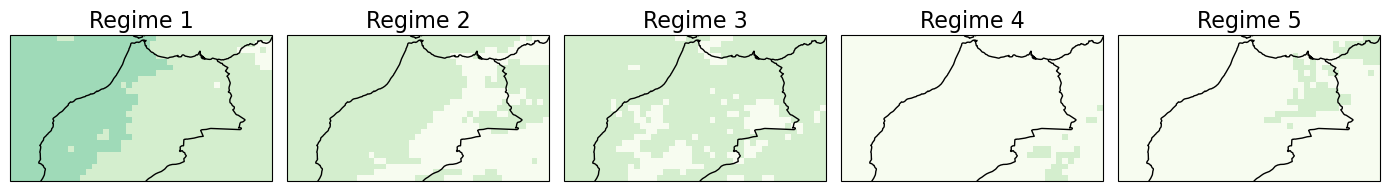

In [9]:
# Calculate and plot AE precipitation odds ratios
pr_qn95_ratio_ae = cf.calculate_conditional_probability_change(threshold_matrix=threshold_qn95,
                                                               kmeans=ae_clusters,
                                                               comparison='ratio', shift_value=0)
pr_qn95_vis_ae = cf.visualise_spatial_oddsratio(dataset_xarray=pr_qn95_ratio_ae, unit='',
                                                cluster_order=cluster_order_ae,
                                                color_scheme='GnBu', vmin=0, vmax=6, steps=7,
                                                title='Odds ratio of 95th percentile precipitation (AE)',
                                                regime_names=[f'Regime {i+1}' for i in range(k)],
                                                borders=True, projection=ccrs.PlateCarree(central_longitude=0),
                                                col_number=k)
plt.savefig(filepath_ae + f'oddsratio_95_{k}.png')

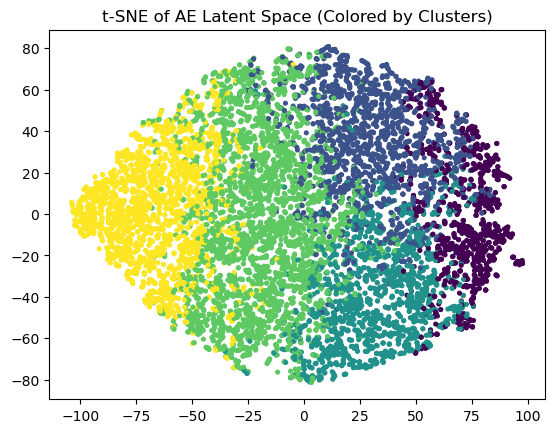

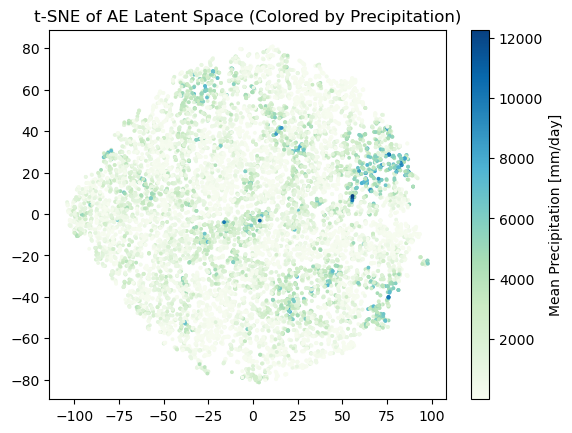

In [10]:
# Apply t-SNE to AE latent space
X_embedded_z500_ae = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(z500_latent_ae)

# Plot t-SNE colored by AE clusters
plt.figure()
scatter_ae_clusters = plt.scatter(X_embedded_z500_ae[:, 0], X_embedded_z500_ae[:, 1], c=relabeled_labels_ae, s=7, cmap='viridis')
plt.title('t-SNE of AE Latent Space (Colored by Clusters)')
plt.savefig(filepath_ae + 'tsne_clusters.png')
plt.show()

# Plot t-SNE colored by precipitation
plt.figure()
scatter_ae_pr = plt.scatter(X_embedded_z500_ae[:, 0], X_embedded_z500_ae[:, 1], c=pr_spatial.values, cmap='GnBu', s=3, alpha=1)
plt.title('t-SNE of AE Latent Space (Colored by Precipitation)')
plt.colorbar(label='Mean Precipitation [mm/day]')
plt.savefig(filepath_ae + 'tsne_precipitation.png')
plt.show()

### 2.3 AE Reconstruction Analysis

393/393 [==============================] - 0s 538us/step
Mean Reconstruction MSE (AE): 0.03443729132413864


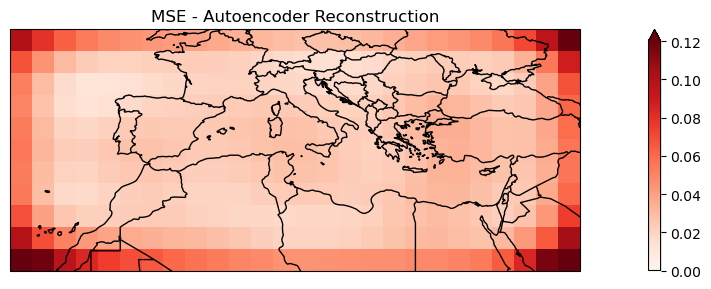

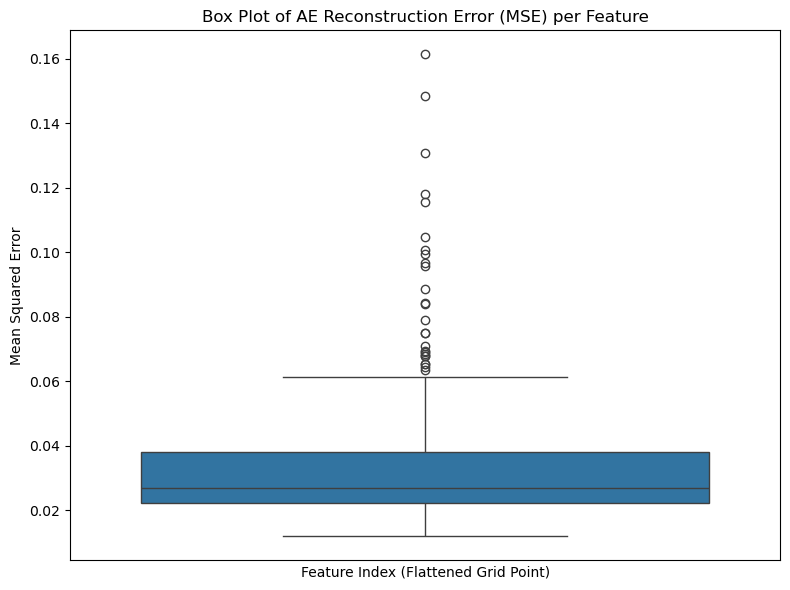

In [11]:
# Reconstruct the full dataset using the trained AE
reconstructed_ae_reshaped = autoencoder_ae.predict(z500_reshaped)

# Calculate MSE
mse_ae = mean_squared_error(z500_reshaped, reconstructed_ae_reshaped, multioutput='raw_values')
mse_ae_reshaped = mse_ae.reshape(ny, nx, order='F')
mse_ae_reshaped_xr = xr.DataArray(mse_ae_reshaped, coords=z500[0, :, :].coords, dims=z500[0, :, :].dims, attrs=z500[0, :, :].attrs)
mean_mse_ae = np.mean(mse_ae)
print(f"Mean Reconstruction MSE (AE): {mean_mse_ae}")

# Visualize MSE
fig_mse_ae = plt.figure(figsize=[14, 3])
ax_mse_ae = fig_mse_ae.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
mse_ae_reshaped_xr.plot(ax=ax_mse_ae, cmap='Reds', transform=ccrs.PlateCarree(), vmin=0, vmax=np.percentile(mse_ae, 99))
ax_mse_ae.coastlines()
ax_mse_ae.add_feature(cartopy.feature.BORDERS)
ax_mse_ae.set_title('MSE - Autoencoder Reconstruction')
plt.tight_layout()
plt.savefig(filepath_ae + 'reconstructed_mse.png')
plt.show()

# Box plot of reconstruction error
plt.figure(figsize=(8, 6))
sns.boxplot(data=mse_ae)
plt.title('Box Plot of AE Reconstruction Error (MSE) per Feature')
plt.ylabel('Mean Squared Error')
plt.xlabel('Feature Index (Flattened Grid Point)')
plt.xticks([])
plt.tight_layout()
plt.savefig(filepath_ae + 'reconstruction_mse_boxplot.png')
plt.show()

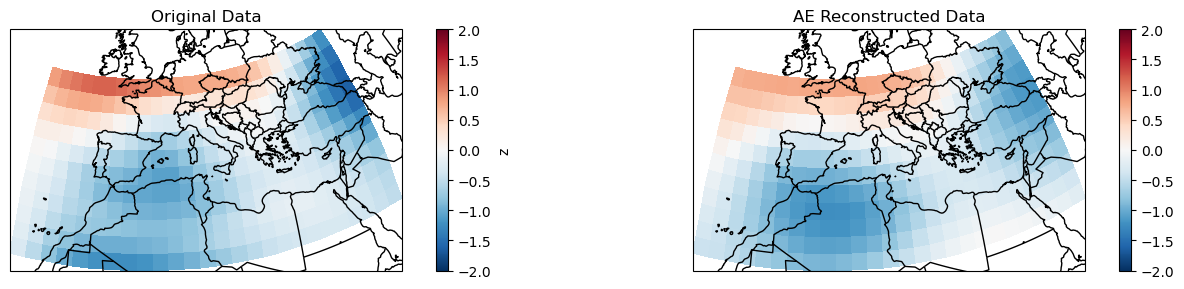

In [12]:
# Visualize an example AE reconstruction
reconstructed_ae = reconstructed_ae_reshaped.reshape(nt, ny, nx, order='F')
reconstructed_ae_xr = xr.DataArray(reconstructed_ae, coords=z500.coords, dims=z500.dims, attrs=z500.attrs)

fig_rec_ex_ae = plt.figure(figsize=[14, 3])
count = 10 # Example time step

ax1_rec_ae = fig_rec_ex_ae.add_subplot(121, projection=ccrs.Orthographic(0, 45))
z500[count, :, :].plot(ax=ax1_rec_ae, cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-2, vmax=2)
ax1_rec_ae.coastlines()
ax1_rec_ae.add_feature(cartopy.feature.BORDERS)
ax1_rec_ae.set_title('Original Data')

ax2_rec_ae = fig_rec_ex_ae.add_subplot(122, projection=ccrs.Orthographic(0, 45))
reconstructed_ae_xr[count, :, :].plot(ax=ax2_rec_ae, cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-2, vmax=2)
ax2_rec_ae.coastlines()
ax2_rec_ae.add_feature(cartopy.feature.BORDERS)
ax2_rec_ae.set_title('AE Reconstructed Data')

plt.tight_layout()
plt.savefig(filepath_ae + f'reconstructed_example_{count}.png')
plt.show()

## 3. Conditional Autoencoder (CAE)

### 3.1 Build and Train CAE

Model: "conditional_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 286)]             0         
                                                                 
 encoder_dense_1 (Dense)     (None, 256)               73472     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 encoder_dense_2 (Dense)     (None, 32)                8224      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 latent_space (Dense)        (None, 10)                330       
                                                                 
 decoder_dense_1 (Dense)     (None, 32)    

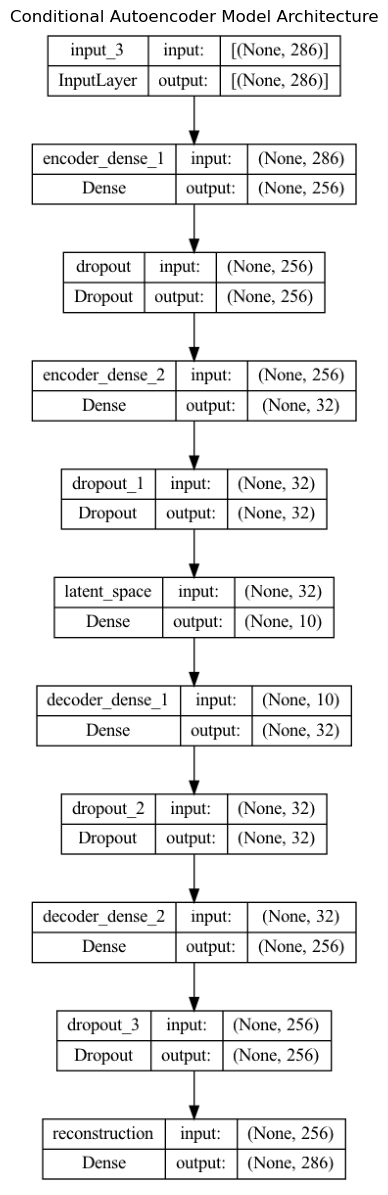

Epoch 1/50
314/314 [==============================] - 1s 2ms/step - loss: 0.4067 - val_loss: 0.2674
Epoch 2/50
314/314 [==============================] - 1s 2ms/step - loss: 0.2859 - val_loss: 0.2359
Epoch 3/50
314/314 [==============================] - 1s 2ms/step - loss: 0.2560 - val_loss: 0.2147
Epoch 4/50
314/314 [==============================] - 1s 2ms/step - loss: 0.2378 - val_loss: 0.2021
Epoch 5/50
314/314 [==============================] - 1s 2ms/step - loss: 0.2278 - val_loss: 0.1979
Epoch 6/50
314/314 [==============================] - 1s 2ms/step - loss: 0.2197 - val_loss: 0.1801
Epoch 7/50
314/314 [==============================] - 1s 2ms/step - loss: 0.2154 - val_loss: 0.1922
Epoch 8/50
314/314 [==============================] - 1s 2ms/step - loss: 0.2114 - val_loss: 0.1911
Epoch 9/50
314/314 [==============================] - 1s 2ms/step - loss: 0.2084 - val_loss: 0.1882
Epoch 10/50
314/314 [==============================] - 1s 2ms/step - loss: 0.2076 - val_loss: 0.1995

In [13]:
autoencoder_cae, encoder_cae, decoder_cae = ae_models.build_conditional_autoencoder(input_dim, latent_dim)
autoencoder_cae.compile(optimizer='adam', loss='mse')
autoencoder_cae.summary()

# Plot model architecture
model_diagram_path_cae = filepath_cae + 'conditional_autoencoder_diagram.png'
tf.keras.utils.plot_model(autoencoder_cae, to_file=model_diagram_path_cae, show_shapes=True, show_layer_names=True)
img_cae = plt.imread(model_diagram_path_cae)
plt.figure(figsize=(10, 15))
plt.imshow(img_cae)
plt.axis('off')
plt.title('Conditional Autoencoder Model Architecture')
plt.show()

# Train CAE (predict next step, no random shuffle for split)
history_cae = ae_training.train_conditional_autoencoder(autoencoder_cae, z500_reshaped, epochs=epochs, batch_size=batch_size, validation_split=0.2, random_state=None, save_path=filepath_cae+'model.keras')

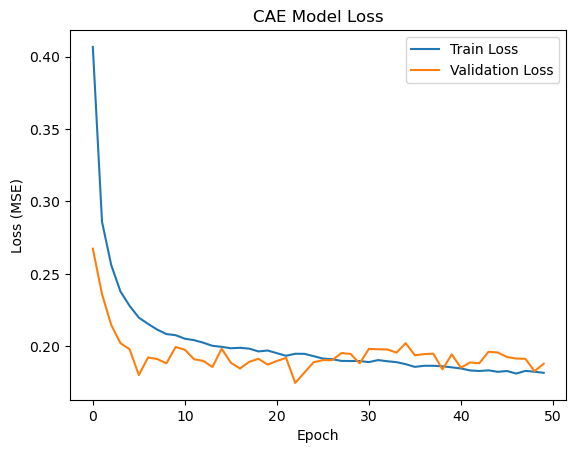

In [14]:
# Plot CAE training loss
plt.figure()
plt.plot(history_cae.history['loss'], label='Train Loss')
plt.plot(history_cae.history['val_loss'], label='Validation Loss')
plt.title('CAE Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(filepath_cae + 'training_loss.png')
plt.show()

### 3.2 CAE Latent Space Clustering and Analysis

In [15]:
# Get CAE latent representation (using data up to T-1 to match training)
z500_latent_cae = encoder_cae.predict(z500_reshaped[:-1])

# K-means clustering
cae_clusters = KMeans(n_clusters=k, n_init=50, random_state=0).fit(z500_latent_cae)
latent_centroids_cae = cae_clusters.cluster_centers_

# Decode centroids
centroids_reconstructed_cae = decoder_cae.predict(latent_centroids_cae)
centroids_cae = centroids_reconstructed_cae.reshape(k, ny, nx, order='F')
centroids_cae_xr = xr.DataArray(centroids_cae, coords=z500[0:k, :, :].coords, dims=z500[0:k, :, :].dims, attrs=z500[0:k, :, :].attrs)

# Save centroids
centroids_cae_flat = cf.reshape_data_for_clustering(centroids_cae_xr)
df_cae_centroids = pd.DataFrame(data=centroids_cae_flat)
df_cae_centroids.to_csv(filepath_cae + f'cluster_centers_{k}.csv')

1/1 [==============================] - 0s 23ms/step


CAE Silhouette Score for k=4: 0.23677991330623627
CAE Silhouette Score for k=5: 0.2128029763698578
CAE Silhouette Score for k=6: 0.2224656194448471
CAE Silhouette Score for k=7: 0.20558086037635803
CAE Silhouette Score for k=8: 0.1944030523300171
CAE Silhouette Score for k=9: 0.17603400349617004
CAE Silhouette Score for k=10: 0.17112720012664795


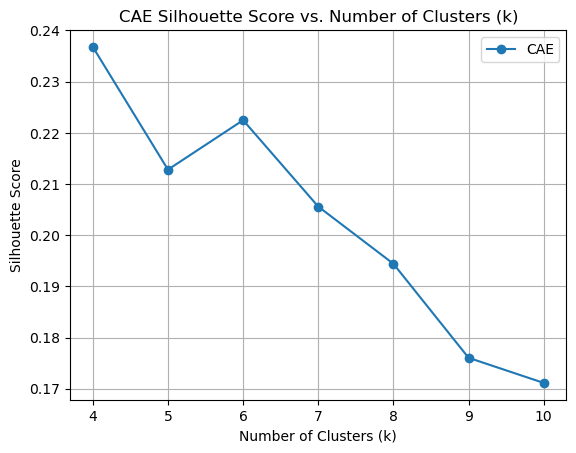

In [16]:
# Calculate and plot Silhouette Score for CAE
silhouette_scores_cae = []
for k_test in k_range:
    kmeans_test = KMeans(n_clusters=k_test, n_init=50, random_state=0).fit(z500_latent_cae)
    score = silhouette_score(z500_latent_cae, kmeans_test.labels_)
    silhouette_scores_cae.append(score)
    print(f'CAE Silhouette Score for k={k_test}: {score}')

plt.figure()
plt.plot(k_range, silhouette_scores_cae, marker='o', label='CAE')
plt.title('CAE Silhouette Score vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.legend()
plt.savefig(filepath_cae + 'silhouette_score_vs_k.png')
plt.show()

In [17]:
# Reorder CAE cluster labels based on precipitation
# Use labels corresponding to the input time steps (t) for precipitation at time t+1
pr_labeled_cae = cf.assign_labels(xarray_array=pr[1:], labels=cae_clusters.labels_)
pr_by_label_cae = pr_labeled_cae.groupby('label').mean(dim=['time', 'latitude', 'longitude'])
cluster_order_cae = np.flip(np.argsort(pr_by_label_cae.values)).tolist()
dict_replace_cae = {i: cluster_order_cae.index(i) for i in range(k)}
vfunc_cae = np.vectorize(lambda x: dict_replace_cae.get(x, x))
relabeled_labels_cae = vfunc_cae(cae_clusters.labels_)
df_cae_labels = pd.DataFrame({'Labels': 'CAE', 'Value': relabeled_labels_cae})
df_cae_labels.to_csv(filepath_cae + 'relabeled_labels.csv')

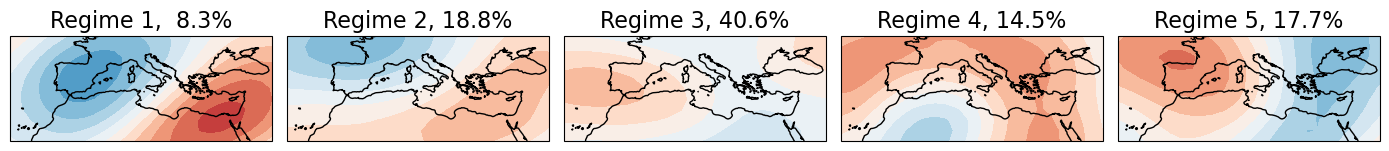

In [18]:
# Visualise CAE cluster centers (representing the *predicted* state)
clusters_cae_vis = cf.visualise_contourplot(dataset_xarray=centroids_cae_xr,
                                           unit='[m]',
                                           cluster_results=cae_clusters,
                                           cluster_order=cluster_order_cae,
                                           regime_names=[f'Regime {i+1}' for i in range(k)],
                                           vmin=-1.7, vmax=1.7, steps=0.2, col_number=k,
                                           color_scheme='RdBu_r', borders=False,
                                           projection=ccrs.PlateCarree(central_longitude=0))
plt.savefig(filepath_cae + f'cluster_visualisation_{k}.png')

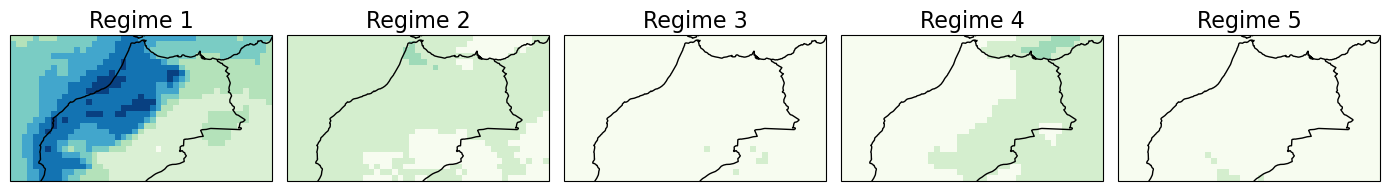

In [19]:
# Calculate and plot CAE precipitation odds ratios
# Use threshold_qn95[1:] to align with the predicted time step
pr_qn95_ratio_cae = cf.calculate_conditional_probability_change(threshold_matrix=threshold_qn95[1:],
                                                               kmeans=cae_clusters,
                                                               comparison='ratio', shift_value=0)
pr_qn95_vis_cae = cf.visualise_spatial_oddsratio(dataset_xarray=pr_qn95_ratio_cae, unit='',
                                                cluster_order=cluster_order_cae,
                                                color_scheme='GnBu', vmin=0, vmax=6, steps=7,
                                                title='Odds ratio of 95th percentile precipitation (CAE)',
                                                regime_names=[f'Regime {i+1}' for i in range(k)],
                                                borders=True, projection=ccrs.PlateCarree(central_longitude=0),
                                                col_number=k)
plt.savefig(filepath_cae + f'oddsratio_95_{k}.png')

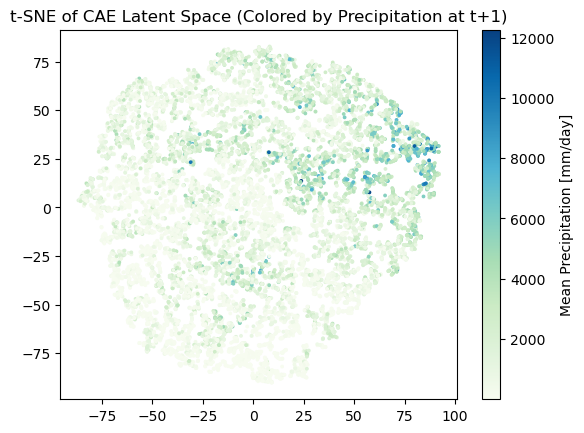

In [20]:
# Apply t-SNE to CAE latent space
X_embedded_z500_cae = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(z500_latent_cae)

# Plot t-SNE colored by CAE clusters
plt.figure()
scatter_cae_clusters = plt.scatter(X_embedded_z500_cae[:, 0], X_embedded_z500_cae[:, 1], c=relabeled_labels_cae, s=7, cmap='viridis')
plt.title('t-SNE of CAE Latent Space (Colored by Clusters)')
plt.savefig(filepath_cae + 'tsne_clusters.png')
plt.show()

# Plot t-SNE colored by precipitation (at t+1)
plt.figure()
scatter_cae_pr = plt.scatter(X_embedded_z500_cae[:, 0], X_embedded_z500_cae[:, 1], c=pr_spatial[1:].values, cmap='GnBu', s=3, alpha=1)
plt.title('t-SNE of CAE Latent Space (Colored by Precipitation at t+1)')
plt.colorbar(label='Mean Precipitation [mm/day]')
plt.savefig(filepath_cae + 'tsne_precipitation.png')
plt.show()

### 3.3 CAE Reconstruction Analysis (Predictive)

393/393 [==============================] - 0s 529us/step
Mean Predictive MSE (CAE): 0.17199784517288208


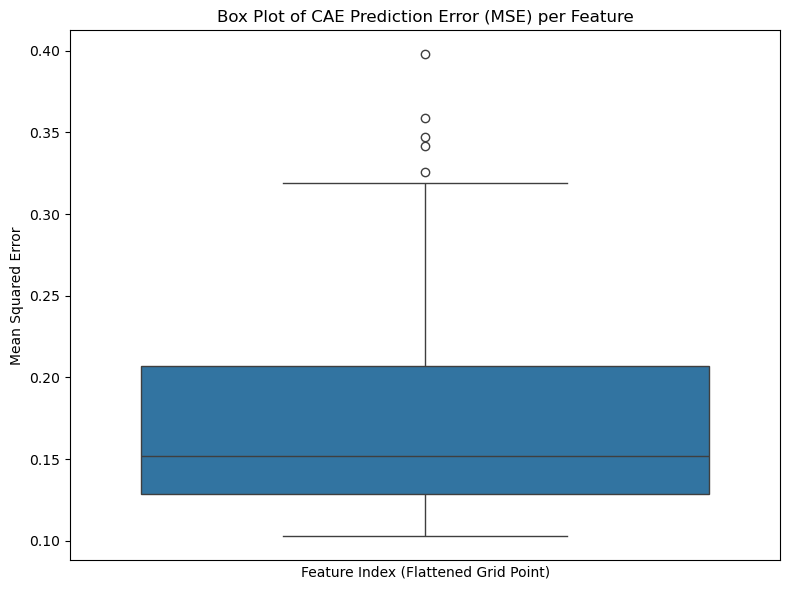

In [21]:
# Reconstruct/Predict the next step for the full dataset using the trained CAE
reconstructed_cae_reshaped = autoencoder_cae.predict(z500_reshaped[:-1])

# Calculate MSE between predicted (t+1) and actual (t+1)
mse_cae = mean_squared_error(z500_reshaped[1:], reconstructed_cae_reshaped, multioutput='raw_values')
mse_cae_reshaped = mse_cae.reshape(ny, nx, order='F')
mse_cae_reshaped_xr = xr.DataArray(mse_cae_reshaped, coords=z500[0, :, :].coords, dims=z500[0, :, :].dims, attrs=z500[0, :, :].attrs)
mean_mse_cae = np.mean(mse_cae)
print(f"Mean Predictive MSE (CAE): {mean_mse_cae}")

# Visualize MSE
fig_mse_cae = plt.figure(figsize=[14, 3])
ax_mse_cae = fig_mse_cae.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
mse_cae_reshaped_xr.plot(ax=ax_mse_cae, cmap='Reds', transform=ccrs.PlateCarree(), vmin=0, vmax=np.percentile(mse_cae, 99))
ax_mse_cae.coastlines()
ax_mse_cae.add_feature(cartopy.feature.BORDERS)
ax_mse_cae.set_title('MSE - Conditional Autoencoder Prediction (t+1)')
plt.tight_layout()
plt.savefig(filepath_cae + 'predictive_mse.png')
plt.show()

# Box plot of prediction error
plt.figure(figsize=(8, 6))
sns.boxplot(data=mse_cae)
plt.title('Box Plot of CAE Prediction Error (MSE) per Feature')
plt.ylabel('Mean Squared Error')
plt.xlabel('Feature Index (Flattened Grid Point)')
plt.xticks([])
plt.tight_layout()
plt.savefig(filepath_cae + 'predictive_mse_boxplot.png')
plt.show()

In [22]:
# Visualize an example CAE prediction
reconstructed_cae = reconstructed_cae_reshaped.reshape(nt-1, ny, nx, order='F')
reconstructed_cae_xr = xr.DataArray(reconstructed_cae, coords=z500[1:].coords, dims=z500[1:].dims, attrs=z500[1:].attrs)

fig_rec_ex_cae = plt.figure(figsize=[14, 6]) # Increased height
count = 10 # Example time step index (predicting step count+1 from step count)

# Input Data (t)
ax0_rec_cae = fig_rec_ex_cae.add_subplot(131, projection=ccrs.Orthographic(0, 45))
z500[count, :, :].plot(ax=ax0_rec_cae, cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-2, vmax=2, add_colorbar=False)
ax0_rec_cae.coastlines()
ax0_rec_cae.add_feature(cartopy.feature.BORDERS)
ax0_rec_cae.set_title(f'Input Data (t={count})')

# Actual Data (t+1)
ax1_rec_cae = fig_rec_ex_cae.add_subplot(132, projection=ccrs.Orthographic(0, 45))
z500[count+1, :, :].plot(ax=ax1_rec_cae, cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-2, vmax=2, add_colorbar=False)
ax1_rec_cae.coastlines()
ax1_rec_cae.add_feature(cartopy.feature.BORDERS)
ax1_rec_cae.set_title(f'Actual Data (t={count+1})')

# CAE Predicted Data (t+1)
ax2_rec_cae = fig_rec_ex_cae.add_subplot(133, projection=ccrs.Orthographic(0, 45))
pcm = reconstructed_cae_xr[count, :, :].plot(ax=ax2_rec_cae, cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-2, vmax=2, add_colorbar=False)
ax2_rec_cae.coastlines()
ax2_rec_cae.add_feature(cartopy.feature.BORDERS)
ax2_rec_cae.set_title(f'CAE Predicted Data (t={count+1})')

# Add a single colorbar
cbar_ax = fig_rec_ex_cae.add_axes([0.92, 0.15, 0.02, 0.7]) # Adjust position and size as needed
fig_rec_ex_cae.colorbar(pcm, cax=cbar_ax, label='Standardized Z500 Anomaly')

plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for colorbar
plt.savefig(filepath_cae + f'predicted_example_{count+1}.png')
plt.show()

/var/folders/vt/sk9k3wzj2ng7y1hz3zclgcf80000gn/T/ipykernel_9772/2763873437.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for colorbar


## 4. Comparison: AE vs CAE

In [23]:
# Compare Training Loss on a single plot
plt.figure(figsize=(8, 5))

plt.plot(history_ae.history['loss'], label='AE Train Loss', color='blue', linestyle='--')
plt.plot(history_ae.history['val_loss'], label='AE Validation Loss', color='blue')
plt.plot(history_cae.history['loss'], label='CAE Train Loss', color='orange', linestyle='--')
plt.plot(history_cae.history['val_loss'], label='CAE Validation Loss', color='orange')

plt.title('AE vs CAE Model Loss Comparison')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(filepath_combined + 'training_loss_comparison.png')
plt.show()


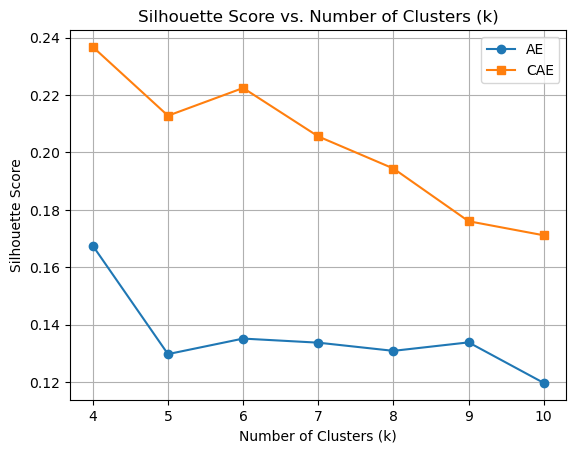

In [24]:
# Compare Silhouette Scores
plt.figure()
plt.plot(k_range, silhouette_scores_ae, marker='o', label='AE')
plt.plot(k_range, silhouette_scores_cae, marker='s', label='CAE')
plt.title('Silhouette Score vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.legend()
plt.savefig(filepath_combined + 'silhouette_score_comparison.png')
plt.show()

In [25]:
# Compare Cluster Centers (k=5)
fig_centers, axes_centers = plt.subplots(nrows=2, ncols=k, figsize=(14, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
fig_centers.suptitle('Cluster Center Comparison (Top: AE, Bottom: CAE)', fontsize=16)

for i in range(k):
    # AE Centers
    ax_ae = axes_centers[0, i]
    idx_ae = cluster_order_ae[i]
    centroids_ae_xr.isel(time=idx_ae).plot(ax=ax_ae, cmap='RdBu_r', vmin=-1.7, vmax=1.7, add_colorbar=False, transform=ccrs.PlateCarree())
    ax_ae.coastlines()
    ax_ae.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax_ae.set_title(f'AE Regime {i+1}')

    # CAE Centers
    ax_cae = axes_centers[1, i]
    idx_cae = cluster_order_cae[i]
    centroids_cae_xr.isel(time=idx_cae).plot(ax=ax_cae, cmap='RdBu_r', vmin=-1.7, vmax=1.7, add_colorbar=False, transform=ccrs.PlateCarree())
    ax_cae.coastlines()
    ax_cae.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax_cae.set_title(f'CAE Regime {i+1}')

# Add a single colorbar
cbar_ax = fig_centers.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-1.7, vmax=1.7))
sm._A = [] # Dummy array for colorbar
fig_centers.colorbar(sm, cax=cbar_ax, label='Standardized Z500 Anomaly')

plt.tight_layout(rect=[0, 0, 0.9, 0.95]) # Adjust layout
plt.savefig(filepath_combined + f'cluster_centers_comparison_{k}.png')
plt.show()

/var/folders/vt/sk9k3wzj2ng7y1hz3zclgcf80000gn/T/ipykernel_9772/1887664518.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95]) # Adjust layout


/var/folders/vt/sk9k3wzj2ng7y1hz3zclgcf80000gn/T/ipykernel_9772/2479578341.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


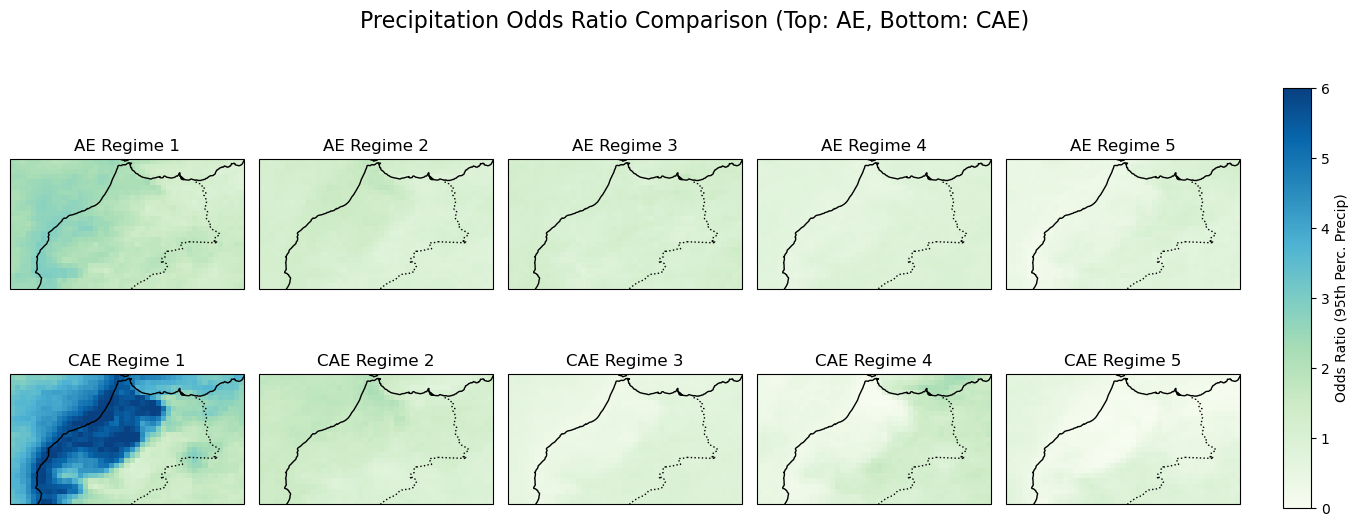

In [26]:
# Compare Odds Ratios (k=5)
fig_odds, axes_odds = plt.subplots(nrows=2, ncols=k, figsize=(14, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
fig_odds.suptitle('Precipitation Odds Ratio Comparison (Top: AE, Bottom: CAE)', fontsize=16)

for i in range(k):
    # AE Odds Ratios
    ax_ae_odds = axes_odds[0, i]
    idx_ae = cluster_order_ae[i]
    pr_qn95_ratio_ae.isel(label=idx_ae).plot(ax=ax_ae_odds, cmap='GnBu', vmin=0, vmax=6, add_colorbar=False, transform=ccrs.PlateCarree())
    ax_ae_odds.coastlines()
    ax_ae_odds.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax_ae_odds.set_title(f'AE Regime {i+1}')

    # CAE Odds Ratios
    ax_cae_odds = axes_odds[1, i]
    idx_cae = cluster_order_cae[i]
    pr_qn95_ratio_cae.isel(label=idx_cae).plot(ax=ax_cae_odds, cmap='GnBu', vmin=0, vmax=6, add_colorbar=False, transform=ccrs.PlateCarree())
    ax_cae_odds.coastlines()
    ax_cae_odds.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax_cae_odds.set_title(f'CAE Regime {i+1}')

# Add a single colorbar
cbar_ax_odds = fig_odds.add_axes([0.92, 0.15, 0.02, 0.7])
sm_odds = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=0, vmax=6))
sm_odds._A = []
fig_odds.colorbar(sm_odds, cax=cbar_ax_odds, label='Odds Ratio (95th Perc. Precip)')

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig(filepath_combined + f'odds_ratio_comparison_{k}.png')
plt.show()

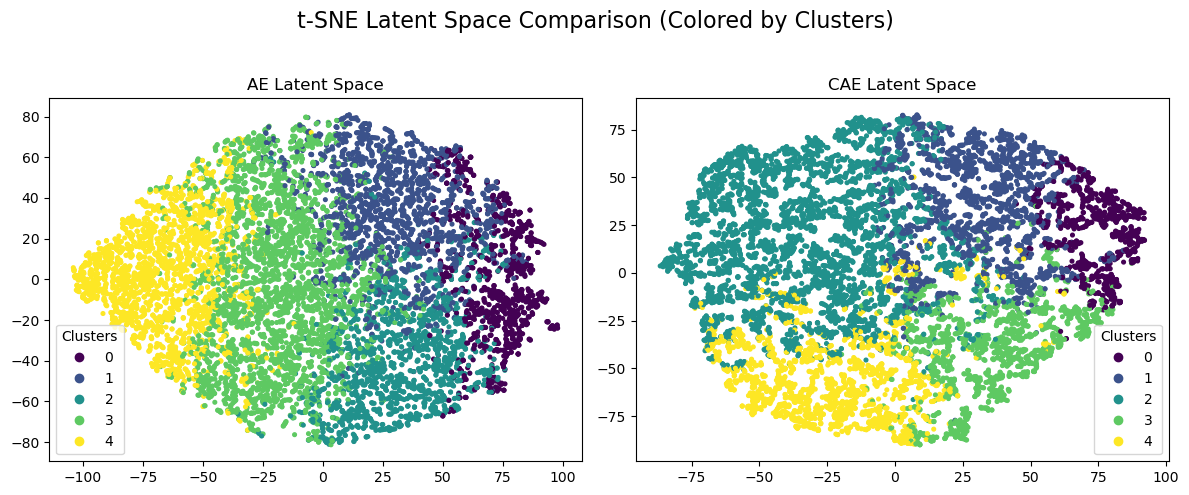

In [27]:
# Compare t-SNE plots (colored by clusters)
fig_tsne_clusters, axes_tsne_clusters = plt.subplots(1, 2, figsize=(12, 5))
fig_tsne_clusters.suptitle('t-SNE Latent Space Comparison (Colored by Clusters)', fontsize=16)

# AE t-SNE
scatter_ae = axes_tsne_clusters[0].scatter(X_embedded_z500_ae[:, 0], X_embedded_z500_ae[:, 1], c=relabeled_labels_ae, s=7, cmap='viridis')
axes_tsne_clusters[0].set_title('AE Latent Space')
axes_tsne_clusters[0].legend(*scatter_ae.legend_elements(), title='Clusters')

# CAE t-SNE
scatter_cae = axes_tsne_clusters[1].scatter(X_embedded_z500_cae[:, 0], X_embedded_z500_cae[:, 1], c=relabeled_labels_cae, s=7, cmap='viridis')
axes_tsne_clusters[1].set_title('CAE Latent Space')
axes_tsne_clusters[1].legend(*scatter_cae.legend_elements(), title='Clusters')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(filepath_combined + 'tsne_clusters_comparison.png')
plt.show()

/var/folders/vt/sk9k3wzj2ng7y1hz3zclgcf80000gn/T/ipykernel_9772/2764673899.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


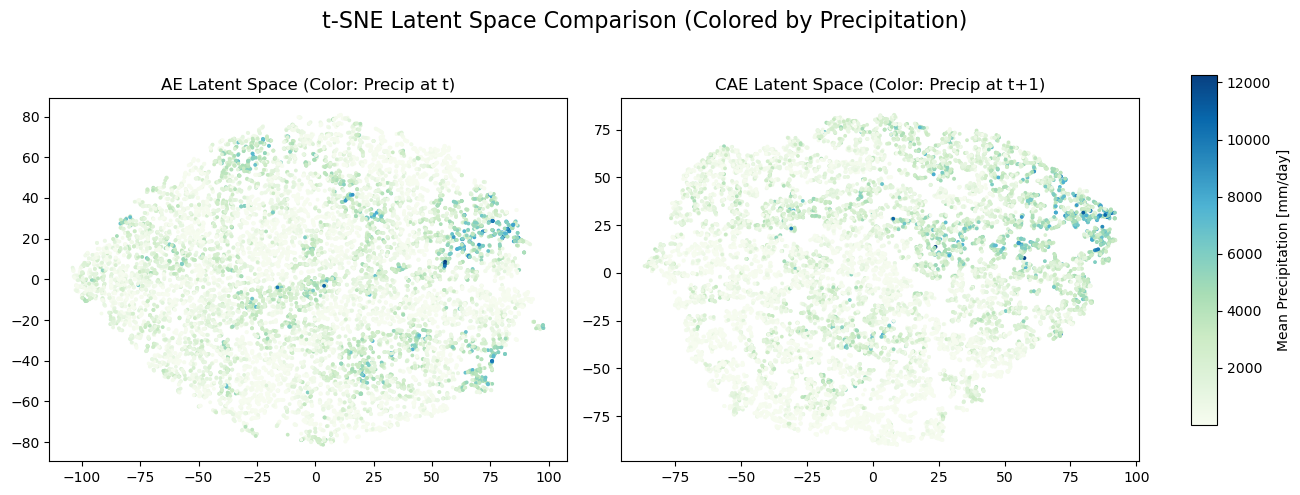

In [28]:
# Compare t-SNE plots (colored by precipitation)
fig_tsne_pr, axes_tsne_pr = plt.subplots(1, 2, figsize=(13, 5)) # Wider figure for colorbar
fig_tsne_pr.suptitle('t-SNE Latent Space Comparison (Colored by Precipitation)', fontsize=16)

# AE t-SNE (colored by pr at time t)
scatter_ae_pr = axes_tsne_pr[0].scatter(X_embedded_z500_ae[:, 0], X_embedded_z500_ae[:, 1], c=pr_spatial.values, cmap='GnBu', s=3, alpha=1)
axes_tsne_pr[0].set_title('AE Latent Space (Color: Precip at t)')

# CAE t-SNE (colored by pr at time t+1)
scatter_cae_pr = axes_tsne_pr[1].scatter(X_embedded_z500_cae[:, 0], X_embedded_z500_cae[:, 1], c=pr_spatial[1:].values, cmap='GnBu', s=3, alpha=1)
axes_tsne_pr[1].set_title('CAE Latent Space (Color: Precip at t+1)')

# Add a single colorbar
cbar_ax_tsne = fig_tsne_pr.add_axes([0.92, 0.15, 0.02, 0.7])
norm_pr = plt.Normalize(vmin=pr_spatial.min(), vmax=pr_spatial.max()) # Use consistent color scale if desired
sm_pr = plt.cm.ScalarMappable(cmap='GnBu', norm=norm_pr)
sm_pr._A = []
fig_tsne_pr.colorbar(sm_pr, cax=cbar_ax_tsne, label='Mean Precipitation [mm/day]')

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig(filepath_combined + 'tsne_precipitation_comparison.png')
plt.show()

Mean Reconstruction MSE (AE): 0.0344
Mean Predictive MSE (CAE): 0.1720


/var/folders/vt/sk9k3wzj2ng7y1hz3zclgcf80000gn/T/ipykernel_9772/2109514492.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.9])


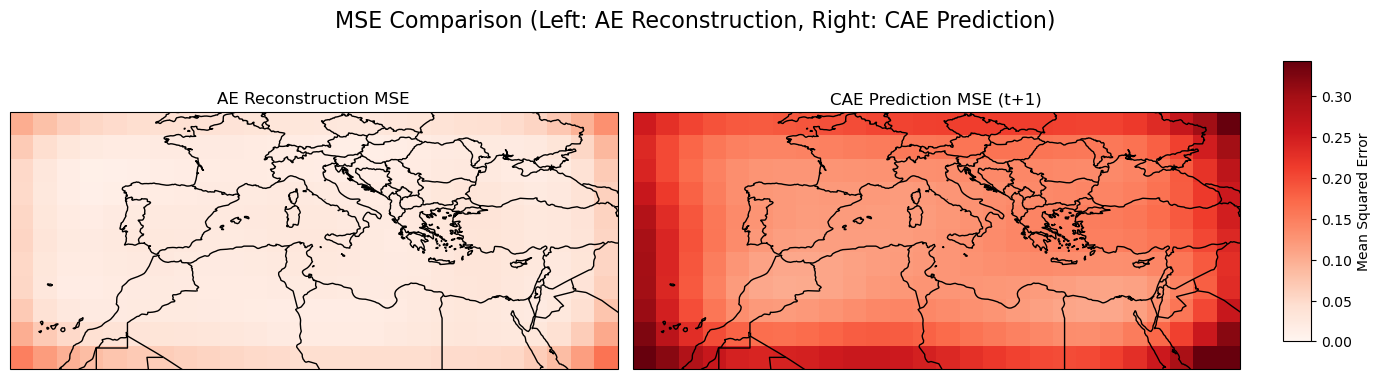

In [29]:
# Compare Reconstruction/Prediction MSE
print(f"Mean Reconstruction MSE (AE): {mean_mse_ae:.4f}")
print(f"Mean Predictive MSE (CAE): {mean_mse_cae:.4f}")

fig_mse, axes_mse = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
fig_mse.suptitle('MSE Comparison (Left: AE Reconstruction, Right: CAE Prediction)', fontsize=16)

# Determine common color scale limits for MSE
mse_vmin = 0
mse_vmax = max(np.percentile(mse_ae, 99), np.percentile(mse_cae, 99))

# AE MSE
pcm_ae_mse = mse_ae_reshaped_xr.plot(ax=axes_mse[0], cmap='Reds', transform=ccrs.PlateCarree(), vmin=mse_vmin, vmax=mse_vmax, add_colorbar=False)
axes_mse[0].coastlines()
axes_mse[0].add_feature(cartopy.feature.BORDERS)
axes_mse[0].set_title('AE Reconstruction MSE')

# CAE MSE
pcm_cae_mse = mse_cae_reshaped_xr.plot(ax=axes_mse[1], cmap='Reds', transform=ccrs.PlateCarree(), vmin=mse_vmin, vmax=mse_vmax, add_colorbar=False)
axes_mse[1].coastlines()
axes_mse[1].add_feature(cartopy.feature.BORDERS)
axes_mse[1].set_title('CAE Prediction MSE (t+1)')

# Add a single colorbar
cbar_ax_mse = fig_mse.add_axes([0.92, 0.15, 0.02, 0.7])
fig_mse.colorbar(pcm_cae_mse, cax=cbar_ax_mse, label='Mean Squared Error')

plt.tight_layout(rect=[0, 0, 0.9, 0.9])
plt.savefig(filepath_combined + 'mse_comparison.png')
plt.show()

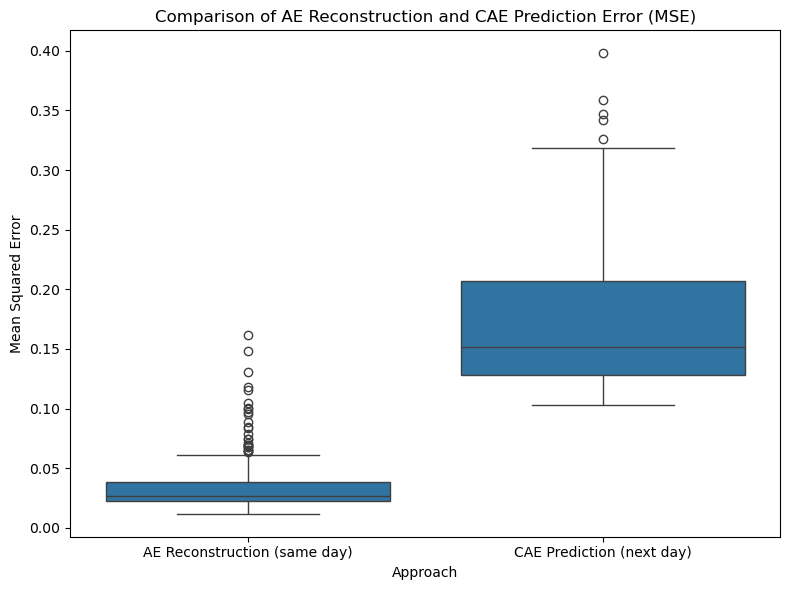

In [30]:
# Prepare data for combined boxplot
df_mse_ae = pd.DataFrame({'MSE': mse_ae, 'Type': 'AE Reconstruction (same day)'})
df_mse_cae = pd.DataFrame({'MSE': mse_cae, 'Type': 'CAE Prediction (next day)'})
df_mse_combined = pd.concat([df_mse_ae, df_mse_cae], ignore_index=True)

# Create the combined box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_mse_combined, x='Type', y='MSE')
plt.title('Comparison of AE Reconstruction and CAE Prediction Error (MSE)')
plt.ylabel('Mean Squared Error')
plt.xlabel('Approach')
plt.tight_layout()
plt.savefig(filepath_combined + 'mse_boxplot_comparison.png')
plt.show()
